In [261]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import re
import seaborn as sns
import time
import heapq

In [191]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import scipy as sp
from scipy.stats import ttest_ind_from_stats

### 1. Import Data and Data Cleaning

In [192]:
raw_data = pd.read_csv('cleaned_data.csv')

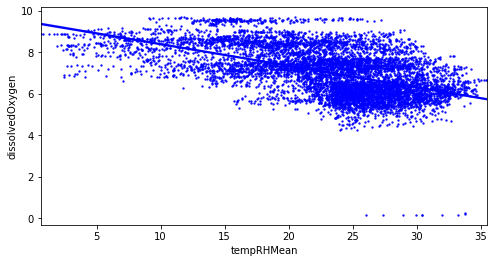

In [193]:
# There are several outliers here.
plt.figure(figsize = (8,4))
ax = sns.regplot(data = raw_data, x='tempRHMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'b', scatter_kws={'s':2})

In [194]:
# outliers - 10 smallest values for dissolvedOxygen. All of them are in June (probably because of some disaster?).
raw_data.sort_values(by='dissolvedOxygen').head(12)

,startDateTime,siteID,dissolvedOxygen,TFPrecipBulk,buoyWindSpeedMean,staPresMean,tempRHMean,uPARMean,PARMean,surfacewaterElevMean,groundwaterTempMean,surfWaterNitrateMean
2802,2019-06-25 13:00:00,BARC,0.170000,0.0,2.370,101.509230,28.9600,196.515000,1074.740,26.96,22.236429,11.050
2803,2019-06-25 14:00:00,BARC,0.170000,0.0,2.990,101.495390,29.9550,293.618333,1399.700,26.96,22.208462,11.050
2800,2019-06-25 11:00:00,BARC,0.170000,0.0,0.550,101.443360,26.0700,39.421667,254.795,26.96,22.235714,11.075
2804,2019-06-25 15:00:00,BARC,0.170000,0.0,3.200,101.518610,30.4270,473.490000,1801.115,26.96,22.235000,11.000
2801,2019-06-25 12:00:00,BARC,0.170000,0.0,1.970,101.511890,27.3375,104.021667,605.905,26.96,22.235714,11.025
2798,2019-06-24 23:00:00,BARC,0.180000,0.0,2.080,101.193500,31.9470,49.406667,238.235,26.97,22.230714,11.050
2799,2019-06-25 00:00:00,BARC,0.180000,0.0,1.180,101.221510,30.4410,4.096667,21.565,26.97,22.230000,11.025
2797,2019-06-24 22:00:00,BARC,0.182500,0.0,2.560,101.189665,33.1925,144.440000,640.560,26.97,22.199231,11.075
2796,2019-06-24 21:00:00,BARC,0.194286,0.0,2.985,101.215005,33.7610,263.265000,1058.755,26.97,22.200000,11.075
2795,2019-06-24 20:00:00,BARC,0.240000,0.0,3.440,101.246845,33.7425,384.921667,1455.225,26.97,22.231429,11.100


In [195]:
# Remove the outliers.
raw_data = raw_data[raw_data['dissolvedOxygen']>4]
raw_data = raw_data.reset_index().drop('index', axis=1)

In [197]:
# Turn startdatetime to year/month/date/time
year, month, date, time = [], [], [], []

for i in range(raw_data.shape[0]):
    text = raw_data['startDateTime'][i]
    pattern = r"([0-9]{4})-([0-9]{2})-([0-9]{2}) ([0-9]+):"
    clock = re.findall(pattern, text)[0]
    year.append(clock[0])
    month.append(clock[1])
    date.append(clock[2])
    time.append(clock[3])

n = raw_data.drop('startDateTime', axis = 1)
new_data = pd.DataFrame({'year':year, 'month':month, 'date':date, "time":time})
new_data = pd.concat([new_data, n], axis = 1)
new_data = new_data.drop('siteID', axis = 1)

In [198]:
new_data_year = new_data.groupby('year').mean()
new_data_month = new_data.groupby('month').mean()
new_data_date = new_data.groupby('date').mean()
new_data_time = new_data.groupby('time').mean()

### 2. Data Visualization 

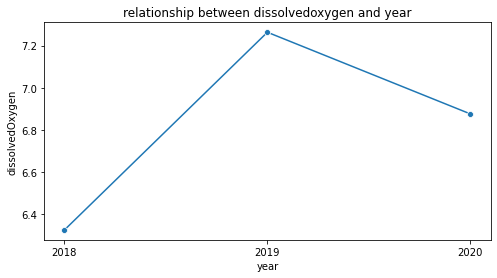

In [199]:
plt.figure(figsize = (8,4))
ax = sns.lineplot(data = new_data_year, x='year', y='dissolvedOxygen', marker = 'o')
ax.set_title('relationship between dissolvedoxygen and year');

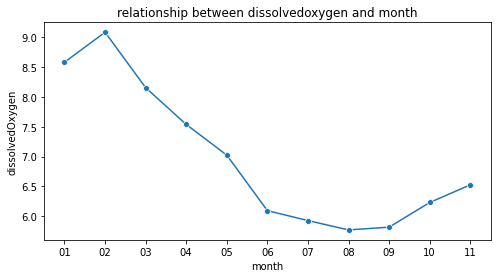

In [200]:
plt.figure(figsize = (8,4))
ax = sns.lineplot(data = new_data_month, x='month', y='dissolvedOxygen', marker = 'o')
ax.set_title('relationship between dissolvedoxygen and month');

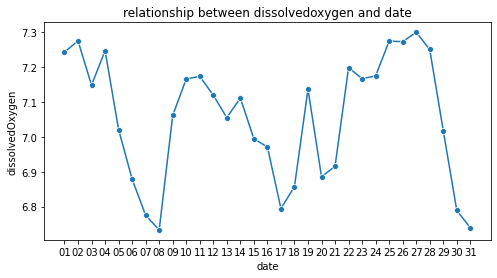

In [201]:
plt.figure(figsize = (8,4))
ax = sns.lineplot(data = new_data_date, x='date', y='dissolvedOxygen', marker = 'o')
ax.set_title('relationship between dissolvedoxygen and date');

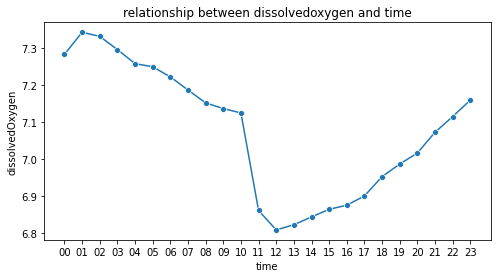

In [202]:
plt.figure(figsize = (8,4))
ax = sns.lineplot(data = new_data_time, x='time', y='dissolvedOxygen', marker = 'o')
ax.set_title('relationship between dissolvedoxygen and time');

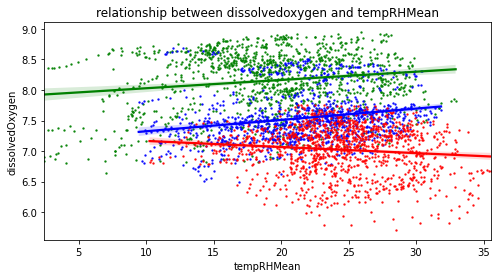

In [203]:
plt.figure(figsize = (8,4))
ax = sns.regplot(data = new_data[new_data['month'] == '03'], x='tempRHMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'g', scatter_kws={'s':2})
ax = sns.regplot(data = new_data[new_data['month'] == '04'], x='tempRHMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'b', scatter_kws={'s':2})
ax = sns.regplot(data = new_data[new_data['month'] == '05'], x='tempRHMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'r', scatter_kws={'s':2})

ax.set_title('relationship between dissolvedoxygen and tempRHMean');

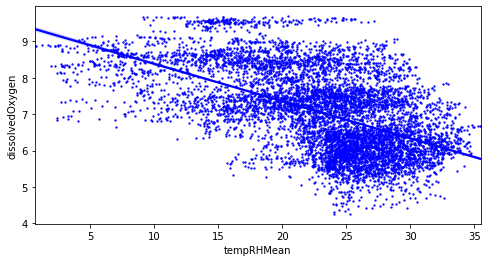

In [204]:
plt.figure(figsize = (8,4))
ax = sns.regplot(data = new_data, x='tempRHMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'b', scatter_kws={'s':2})

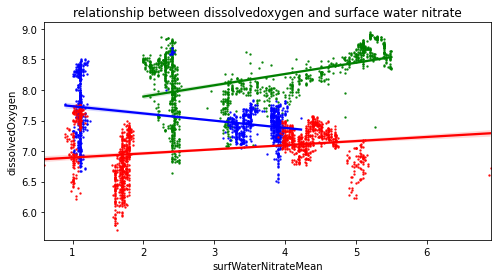

In [205]:
plt.figure(figsize = (8,4))
ax = sns.regplot(data = new_data[new_data['month'] == '03'], x='surfWaterNitrateMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'g', scatter_kws={'s':2})
ax = sns.regplot(data = new_data[new_data['month'] == '04'], x='surfWaterNitrateMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'b', scatter_kws={'s':2})
ax = sns.regplot(data = new_data[new_data['month'] == '05'], x='surfWaterNitrateMean', y='dissolvedOxygen', 
                     marker = 'o', color = 'r', scatter_kws={'s':2})
#ax.set(xscale="log", yscale="log")
ax.set_title('relationship between dissolvedoxygen and surface water nitrate');

In [206]:
new_data[(new_data['year'] == '2018') & (new_data['month'] == '04')]

,year,month,date,time,dissolvedOxygen,TFPrecipBulk,buoyWindSpeedMean,staPresMean,tempRHMean,uPARMean,PARMean,surfacewaterElevMean,groundwaterTempMean,surfWaterNitrateMean


In [207]:
new_data[new_data['year'] == '2018']

,year,month,date,time,dissolvedOxygen,TFPrecipBulk,buoyWindSpeedMean,staPresMean,tempRHMean,uPARMean,PARMean,surfacewaterElevMean,groundwaterTempMean,surfWaterNitrateMean
0,2018,05,24,04,6.610000,0.0,0.345,101.681665,23.9965,0.042500,0.000,26.54,22.111250,6.875
1,2018,05,24,05,6.716667,0.0,0.220,101.652925,23.2985,0.057500,0.000,26.54,22.112500,6.900
2,2018,06,11,22,6.570000,0.0,1.285,101.257395,25.2915,135.810000,452.945,26.67,22.186875,7.950
3,2018,06,12,07,6.480000,0.0,0.295,101.429010,22.7900,0.000000,0.000,26.67,22.192500,8.025
4,2018,06,13,03,6.340000,0.0,0.335,101.665130,23.7270,-0.017500,0.000,26.68,22.196875,7.925
5,2018,06,13,04,6.295000,0.0,0.230,101.681165,23.5465,-0.015000,0.000,26.68,22.196250,7.900
6,2018,06,14,03,6.100000,0.0,1.420,101.702555,25.4275,-0.020000,0.000,26.68,22.198125,7.950
7,2018,06,15,23,6.810000,0.0,1.675,101.443380,26.6200,28.022500,96.210,26.67,22.198750,8.225
8,2018,06,24,17,6.458333,0.0,2.075,101.544815,31.9920,700.143333,2121.865,26.74,22.223750,8.525
9,2018,06,24,18,6.465000,0.0,1.730,101.462930,32.4520,453.587500,1196.885,26.74,22.223125,8.550


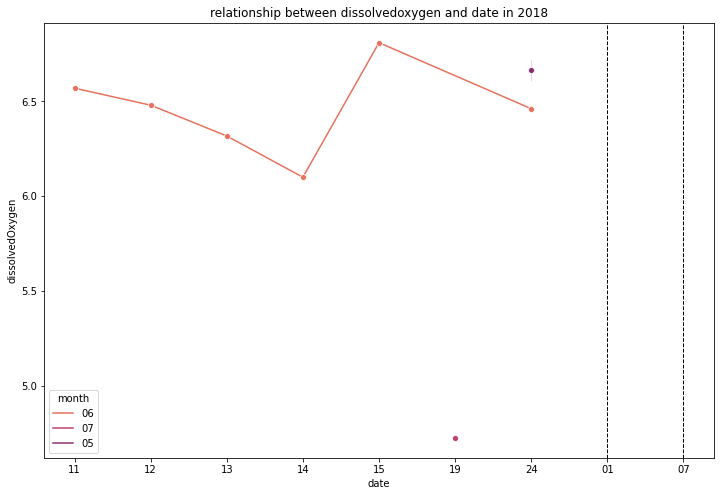

In [208]:
plt.figure(figsize = (12,8))
new_data_1 = new_data.sort_values(by = ['date','month'])
ax = sns.lineplot(data = new_data_1[new_data_1['year'] == '2018'], hue = 'month', x='date', y='dissolvedOxygen', 
                  palette="flare", marker = 'o')
plt.axvline('01', color='k', linestyle='dashed', linewidth=1)
plt.axvline('07', color='k', linestyle='dashed', linewidth=1)

ax.set_title('relationship between dissolvedoxygen and date in 2018');


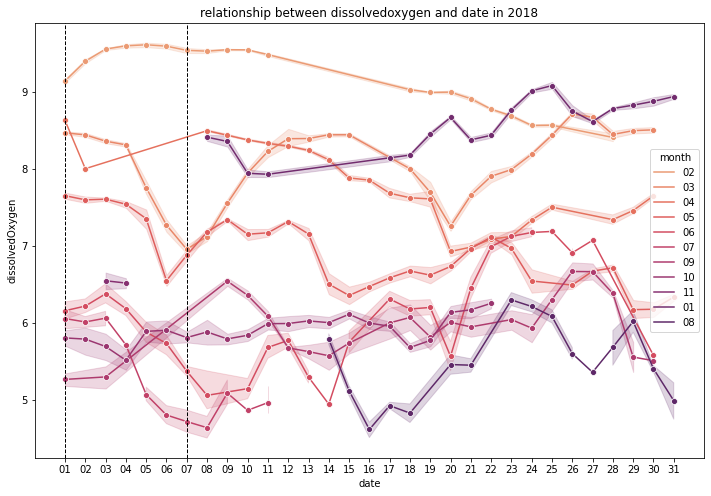

In [209]:
plt.figure(figsize = (12,8))
new_data_1 = new_data.sort_values(by = ['date','month'])
ax = sns.lineplot(data = new_data_1[new_data_1['year'] == '2019'], hue = 'month', x='date', y='dissolvedOxygen', 
                palette="flare", marker = 'o')
plt.axvline('01', color='k', linestyle='dashed', linewidth=1)
plt.axvline('07', color='k', linestyle='dashed', linewidth=1)

ax.set_title('relationship between dissolvedoxygen and date in 2018');


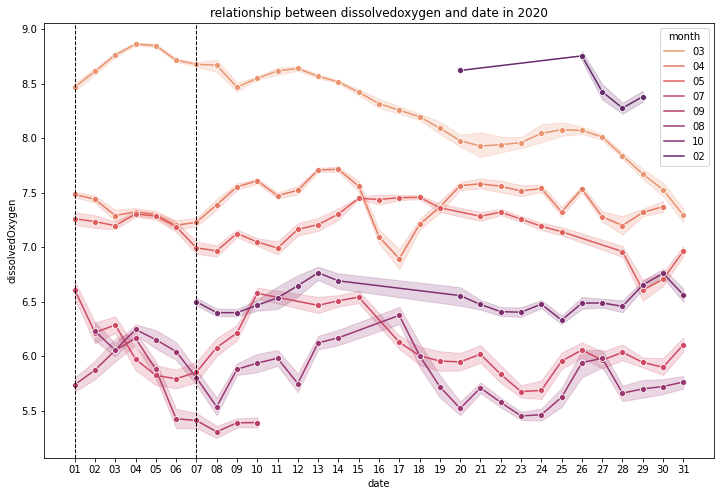

In [210]:
plt.figure(figsize = (12,8))
new_data_1 = new_data.sort_values(by = ['date','month'])
ax = sns.lineplot(data = new_data_1[new_data_1['year'] == '2020'], hue = 'month', x='date', y='dissolvedOxygen', 
                  palette="flare", marker = 'o')
plt.axvline('01', color='k', linestyle='dashed', linewidth=1)
plt.axvline('07', color='k', linestyle='dashed', linewidth=1)

ax.set_title('relationship between dissolvedoxygen and date in 2020');


### 3. Split into training set and test set

In [211]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(new_data, test_size=0.2, random_state=42)

### 4. Normalization

In [212]:
# Normalization
def normalize(cal_data, raw_data):
    normalized_data = (cal_data - np.mean(raw_data)) / np.std(raw_data)
    return normalized_data

def normalize_df(df_cal, df_raw):
    df_cal_2 = df_cal.copy()
    for i in ['TFPrecipBulk', 'buoyWindSpeedMean', 'staPresMean','tempRHMean','uPARMean', 'PARMean',
                    'surfacewaterElevMean','groundwaterTempMean','surfWaterNitrateMean']:
        data_cal = df_cal.loc[:,i]
        data_raw = df_raw.loc[:,i]
        df_cal_2.loc[:,i] = normalize(data_cal, data_raw)
    return df_cal_2

In [222]:
train_data_n = normalize_df(train_data,train_data)
test_data_n = normalize_df(test_data,train_data)

In [223]:
train_data_n = train_data_n[['dissolvedOxygen', 'TFPrecipBulk', 'buoyWindSpeedMean', 'staPresMean','tempRHMean','uPARMean', 'PARMean',
                    'surfacewaterElevMean','groundwaterTempMean','surfWaterNitrateMean']]
test_data_n = test_data_n[['dissolvedOxygen','TFPrecipBulk', 'buoyWindSpeedMean', 'staPresMean','tempRHMean','uPARMean', 'PARMean',
                    'surfacewaterElevMean','groundwaterTempMean','surfWaterNitrateMean']]

In [160]:
def rmse(actual_y, predicted_y):
    return (sum((actual_y - predicted_y) ** 2) / len(actual_y))**0.5

from sklearn.model_selection import KFold
def compute_CV_error(model, X_train, Y_train):
    kf = KFold(n_splits=5)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
        
        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        error = rmse(split_Y_valid, model.predict(split_X_valid))
        validation_errors.append(error)
    return np.mean(validation_errors)

### Random Forest

In [161]:
# Change year/month/date to dummy variables.
#def rearrange(df, column_name):
#    all_types = df[column_name].unique()
#    lst = []
    
#    for i in range(len(all_types)):
#        # i = 0
#        lst.append([])
#        # lst = [[]]
#        for j in df[column_name]:
#            if j == all_types[i]:
#                lst[i] += [1]
#            else:
#                lst[i] += [0]
#    df_new = pd.DataFrame([lst[i] for i in range(len(lst))]).transpose()
#    df_new = df_new.set_axis(all_types, axis=1)
#
#    return df_new

In [225]:
#new_year = rearrange(new_data, 'year').add_suffix('_y')
#new_month = rearrange(new_data, 'month').add_suffix('_m')
#new_date = rearrange(new_data, 'date').add_suffix('_d')

#try_new = pd.concat([new_data, new_year, new_month, new_date], axis=1).drop(['year', 'month', 'date', 'time'], axis=1)
#try_new.head()

In [224]:
test_data_n

,dissolvedOxygen,TFPrecipBulk,buoyWindSpeedMean,staPresMean,tempRHMean,uPARMean,PARMean,surfacewaterElevMean,groundwaterTempMean,surfWaterNitrateMean
5586,7.540833,-0.126656,-0.978476,-4.457971,0.215516,-0.732992,-0.801333,-1.048500,-0.157900,0.726072
2184,6.549167,-0.126656,-1.121158,-0.150739,-0.812316,-0.732787,-0.801248,1.150180,-1.581372,-0.659681
3698,6.066667,-0.126656,-1.348558,-0.477110,-0.705266,-0.733492,-0.802352,0.214196,1.609708,0.104426
6652,5.862500,-0.126656,-1.085488,-0.013478,0.166363,-0.611694,-0.694233,-1.127971,0.486355,0.259837
4727,7.590833,-0.126656,0.310121,-1.886309,-0.069440,-0.732935,-0.801812,-0.818919,0.201151,0.233935
...,...,...,...,...,...,...,...,...,...,...
1593,7.902500,-0.126656,0.715872,0.813975,0.086439,-0.634732,-0.648499,1.185500,-1.390387,-1.009357
2926,4.925833,-0.126656,0.796131,-0.350103,0.909968,0.551144,0.932627,0.620378,0.216430,-0.776239
1512,8.157500,-0.126656,0.778296,-0.083543,0.444516,0.126429,0.599120,1.220820,-1.347097,-1.009357
1871,7.560833,-0.126656,1.259848,1.457492,0.703479,1.221319,1.271500,1.150180,-1.573733,-1.026624


In [226]:
X_train = train_data_n.drop('dissolvedOxygen', axis = 1)
Y_train = train_data['dissolvedOxygen']

X_test = test_data_n.drop('dissolvedOxygen', axis = 1)
Y_test = test_data['dissolvedOxygen']

In [228]:
#max_depth, loop the max depth to see where is the maximum accuracy
#max_features: sqrt=auto>log2, criterion: gini>entropy
from sklearn.ensemble import RandomForestRegressor

model2 = RandomForestRegressor(n_estimators=100,random_state=42,bootstrap = True)
model2.fit(X_train, Y_train)

predicted_Y_train = model2.predict(X_train)

# Accuracy of model - training data
model2_accuracy = model2.score(X_train,Y_train)
display(model2_accuracy)

# Accuracy of model - test data
predicted_Y_test = model2.predict(X_test)
model2_test_accuracy = model2.score(X_test, Y_test)
display(model2_test_accuracy)

0.9970984674443797

0.9844459593224724

In [229]:
#Root mean square error of training data and test data.
rmse(Y_train, predicted_Y_train), rmse(Y_test, predicted_Y_test)

(0.06085577551414742, 0.1430381230706066)

#### Most important features - random forest

In [230]:
X_select = X_train
Y_select = Y_train

In [248]:
import matplotlib.pyplot as plt
model2.fit(X_select,Y_select)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model2.feature_importances_, index=X_select.columns)
feat_importances

TFPrecipBulk            0.000648
buoyWindSpeedMean       0.004125
staPresMean             0.018975
tempRHMean              0.320075
uPARMean                0.003585
PARMean                 0.006017
surfacewaterElevMean    0.349247
groundwaterTempMean     0.222302
surfWaterNitrateMean    0.075026
dtype: float64

In [249]:
importance_all = feat_importances.nlargest(9)
importance_all

surfacewaterElevMean    0.349247
tempRHMean              0.320075
groundwaterTempMean     0.222302
surfWaterNitrateMean    0.075026
staPresMean             0.018975
PARMean                 0.006017
buoyWindSpeedMean       0.004125
uPARMean                0.003585
TFPrecipBulk            0.000648
dtype: float64

In [250]:
importance = feat_importances.nlargest(6)
importance

surfacewaterElevMean    0.349247
tempRHMean              0.320075
groundwaterTempMean     0.222302
surfWaterNitrateMean    0.075026
staPresMean             0.018975
PARMean                 0.006017
dtype: float64

In [251]:
col = list(importance.index)

new_importances = try_new[col]
X_im_train = X_train[col]
Y_im_train = Y_train

X_im_test = X_test[col]
Y_im_test = Y_test

In [252]:
#max_depth, loop the max depth to see where is the maximum accuracy
#max_features: sqrt=auto>log2, criterion: gini>entropy
from sklearn.ensemble import RandomForestRegressor

model3 = RandomForestRegressor(n_estimators=100,random_state=42,bootstrap = True)
model3.fit(X_im_train, Y_im_train)

predicted_Y_train = model3.predict(X_im_train)

model3_accuracy = model3.score(X_im_train,Y_im_train)
display(model3_accuracy)

predicted_Y_test = model3.predict(X_im_test)
model3_test_accuracy = model3.score(X_im_test, Y_im_test)
display(model3_test_accuracy)

0.9971850911625818

0.9846042797716598

In [240]:
rmse(Y_train, predicted_Y_train), rmse(Y_test, predicted_Y_test)

(0.05994048388632396, 0.1423082875868118)

### K-nearest neighbor

In [358]:
X_train_s = X_train.iloc[0:1000]
Y_train_s = Y_train.iloc[0:1000]

In [359]:
def distance(x1, x2, L):
    d = [abs(x1[i] - x2[i])**L for i in range(len(x1))]
    dist = sum(d) ** (1/L)
    return dist

def compute_rmse(predictions, yvalues):
    error = []
    for i in range(len(predictions)):
        error += [(predictions[i] - yvalues[i]) ** 2]
    rmse = np.sqrt(np.mean(error)).round(2)
    return rmse

In [360]:
def compute_CV_error(func1, func2, X_train, Y_train, k, kn):
    #k - number of folds
    #kn - nnearest
    new_index = read_index(X_train, k)
    validation_errors = []
    start_time_cv = time.time()
    
    for i in range(k):
        valid_idx = new_index[i]
    
        train_idx = []
        tt = list(range(k))
        tt.remove(i)
        for j in tt:
            train_idx.extend(new_index[j])
    
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
       
        split_X_train = [split_X_train.iloc[i].values for i in range(split_X_train.shape[0])]
        split_X_valid = [split_X_valid.iloc[i].values for i in range(split_X_valid.shape[0])]
        split_Y_train = [split_Y_train.iloc[i] for i in range(len(split_Y_train))]
        split_Y_valid = [split_Y_valid.iloc[i] for i in range(len(split_Y_valid))]
        
        # Compute the RMSE on the validation split
        if func1 != None:
            error = func1(split_X_train, split_Y_train, split_X_valid, split_Y_valid, 2)[0]
        else:
            error = func2(split_X_train, split_Y_train, split_X_valid, split_Y_valid, 2, kn)[0]
        validation_errors.append(error)
    print("Total time taken: {0:1.2f} seconds".format(time.time() - start_time_cv))
    return validation_errors


def read_index(X_train, k):
    all_index = np.arange(len(X_train))
#    np.random.shuffle(all_index)
    all_index = list(all_index)
    part = len(X_train) // k
    
    new_index = []
    for i in range(k):
        new_index.append(all_index[0:part])
        del all_index[0:part]
    new_index.append(all_index)
    return new_index

In [361]:
def knn(x_train, y_train, x_test, y_test, L, k):
    start_time = time.time()
    y_predicted = []

    for i in range(len(x_test)):
        min_i_lst = list(find_the_knearest(x_train, x_test[i], L, k))
        y_predicted.append(np.mean([y_train[i] for i in min_i_lst]))
    rmse = compute_rmse(y_predicted, y_test)
    print("Time taken: {0:1.2f} seconds".format(time.time() - start_time))
    return rmse, y_predicted

def find_the_knearest(x_train, x_test_specific, L, k):
    
    dist = [distance(x_train[i], x_test_specific, L) for i in range(len(x_train))]
    A = np.array(dist)
    return np.argsort(A)[:k]

In [372]:
cv_rmse = compute_CV_error(None, knn, X_train_s, Y_train_s, 10, 4)
cv_rmse

Time taken: 0.68 seconds
Time taken: 0.68 seconds
Time taken: 0.68 seconds
Time taken: 0.69 seconds
Time taken: 0.69 seconds
Time taken: 0.70 seconds
Time taken: 0.69 seconds
Time taken: 0.69 seconds
Time taken: 0.68 seconds
Time taken: 0.68 seconds
Total time taken: 7.48 seconds


[0.46, 0.46, 0.48, 0.5, 0.57, 0.78, 0.67, 0.62, 0.65, 0.66]

In [373]:
def get_best_k(x_cv, y_cv):
    cv_rmse = []
    for k in range(20):
        cv_rmse.append(np.mean(compute_CV_error(None, knn, x_cv, y_cv, 10, k+1)))
    k = list(range(1,21))
    final_rmse = pd.DataFrame({'k': k, 'rmse': cv_rmse})
    smallest_k = final_rmse.sort_values(by='rmse').iloc[0]['k']
    smallest_rmse = final_rmse.sort_values(by='rmse').iloc[0]['rmse'] 
    
    return smallest_k, smallest_rmse

In [374]:
def forward_feature_selection(df,n):
    feature_selected = []
    all_rmse = []
    all_related_k = []
    y_cv = df['dissolvedOxygen']

    for num_features in range(n):
        col = list(df.columns[:-1].copy())
        for i in feature_selected:
            col.remove(i)
    
        best_feature = col[0]
        smallest_rmse = get_best_k(df[col[0]].to_frame(), y_cv)[1]
    
        for i in col:
            if feature_selected == []:
                x_cv = df[i].to_frame()
            else:
                col_current = feature_selected + [i]
                x_cv = df[col_current]
            current_rmse = get_best_k(x_cv, y_cv)[1]
            current_k = get_best_k(x_cv, y_cv)[0]
            if current_rmse < smallest_rmse:
                smallest_rmse = current_rmse
                best_feature = i
                related_k = current_k
        feature_selected.append(best_feature)
        all_rmse.append(smallest_rmse)
        all_related_k.append(related_k)
    return feature_selected, all_rmse, all_related_k

In [375]:
final_data = X_train_s.copy()
final_data['dissolvedOxygen'] = Y_train_s

In [376]:
#final_data = final_data.drop(['PARMean', 'buoyWindSpeedMean', 'uPARMean', 'TFPrecipBulk'], axis=1)
#final_data

In [377]:
final_feature = forward_feature_selection(final_data,6)

Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Total time taken: 2.07 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.16 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Total time taken: 2.07 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Total time taken: 2.09 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time ta

Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Total time taken: 2.07 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Total time taken: 2.06 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.09 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time ta

Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Total time taken: 2.05 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.07 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Total time taken: 2.13 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Total time taken: 2.13 seconds
T

Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Total time taken: 2.14 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Total time taken: 2.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.12 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
T

Time taken: 0.15 seconds
Total time taken: 2.14 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.13 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Total time taken: 2.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
T

Time taken: 0.19 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.17 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Total time taken: 2.13 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.17 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time ta

Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.11 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.13 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time ta

Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Total time taken: 2.15 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Total time taken: 2.14 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.12 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Total t

Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Total time taken: 2.11 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.13 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Total time taken: 2.14 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
T

Time taken: 0.15 seconds
Total time taken: 2.13 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Total time taken: 2.12 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.12 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Total time taken: 2.14 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
T

Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.11 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Total time taken: 2.12 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.17 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.17 seconds
Total time taken: 2.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time ta

Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Total time taken: 2.11 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.14 seconds
Time taken: 0.15 seconds
Time taken: 0.17 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.14 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time ta

Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.17 seconds
Time taken: 0.15 seconds
Total time taken: 2.12 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.18 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.13 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.09 seconds
Time taken: 0.15 seconds
T

Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.13 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Total time taken: 2.04 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Total time taken: 2.03 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Total time taken: 2.05 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
T

Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Total time taken: 2.77 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.21 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.77 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.23 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.21 seconds
Time taken: 0.21 seconds
Time taken: 0.21 seconds
Total time taken: 2.74 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time ta

Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.21 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.77 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.78 seconds
Time taken: 0.23 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.78 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time ta

Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.80 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.78 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.78 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.21 seconds
Total t

Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.79 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Total time taken: 2.78 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.78 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.79 seconds
Time taken: 0.22 seconds
T

Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.79 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.81 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.77 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Total time taken: 2.80 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
T

Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Total time taken: 2.76 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.24 seconds
Time taken: 0.22 seconds
Total time taken: 2.78 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.79 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.21 seconds
Time ta

Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Total time taken: 2.79 seconds
Time taken: 0.22 seconds
Time taken: 0.26 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.84 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.79 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time ta

Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.81 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.78 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.77 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Total t

Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.24 seconds
Time taken: 0.22 seconds
Total time taken: 2.82 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.78 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.78 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Total time taken: 2.81 seconds
Time taken: 0.21 seconds
T

Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.78 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.79 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.78 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Total time taken: 2.79 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
T

Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Total time taken: 2.79 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Total time taken: 2.78 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.23 seconds
Total time taken: 2.80 seconds
Time taken: 0.21 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.22 seconds
Time ta

Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Total time taken: 2.05 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Total time taken: 2.07 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Total time taken: 2.06 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time ta

Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Total time taken: 3.45 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Total time taken: 3.43 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.30 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.30 seconds
Time taken: 0.29 seconds
Time taken: 0.32 seconds
Time taken: 0.32 seconds
Total time taken: 3.59 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Total time taken: 3.49 seconds
T

Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Total time taken: 3.45 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.30 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Total time taken: 3.45 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Total time taken: 3.43 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Total time taken: 3.44 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
T

Time taken: 0.28 seconds
Total time taken: 3.43 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Total time taken: 3.42 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Total time taken: 3.42 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Total time taken: 3.43 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
T

Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Total time taken: 3.45 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.30 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Total time taken: 3.47 seconds
Time taken: 0.28 seconds
Time taken: 0.30 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Total time taken: 3.46 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time ta

Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Total time taken: 3.43 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Total time taken: 3.44 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Total time taken: 3.43 seconds
Time taken: 0.30 seconds
Time taken: 0.29 seconds
Time taken: 0.30 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time ta

Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.30 seconds
Total time taken: 3.47 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.30 seconds
Time taken: 0.28 seconds
Total time taken: 3.45 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Total time taken: 3.45 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.30 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.31 seconds
Total t

Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Total time taken: 3.43 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Total time taken: 3.46 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.36 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Total time taken: 3.54 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Total time taken: 3.45 seconds
Time taken: 0.29 seconds
T

Time taken: 0.28 seconds
Time taken: 0.28 seconds
Total time taken: 3.41 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Total time taken: 3.42 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.30 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Total time taken: 3.43 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Total time taken: 3.41 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
T

Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.30 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Total time taken: 3.46 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.30 seconds
Time taken: 0.29 seconds
Total time taken: 3.44 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.28 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Total time taken: 3.47 seconds
Time taken: 0.29 seconds
Time taken: 0.29 seconds
Time taken: 0.30 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time taken: 0.28 seconds
Time ta

Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Total time taken: 2.06 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Total time taken: 2.08 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Total time taken: 2.07 seconds
Time taken: 0.14 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.14 seconds
Time taken: 0.15 seconds
Time ta

Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Total time taken: 4.07 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Total time taken: 4.02 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.35 seconds
Total time taken: 4.08 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Total time taken: 4.03 seconds
T

Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Total time taken: 4.04 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Total time taken: 4.04 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Total time taken: 4.05 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Total time taken: 4.07 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
T

Time taken: 0.34 seconds
Total time taken: 4.05 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Total time taken: 4.06 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.37 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Total time taken: 4.08 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Total time taken: 4.09 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
T

Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Total time taken: 4.06 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Total time taken: 4.08 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.37 seconds
Time taken: 0.37 seconds
Time taken: 0.35 seconds
Time taken: 0.36 seconds
Total time taken: 4.12 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time ta

Time taken: 0.36 seconds
Time taken: 0.35 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Total time taken: 4.07 seconds
Time taken: 0.35 seconds
Time taken: 0.36 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Total time taken: 4.08 seconds
Time taken: 0.35 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Total time taken: 4.08 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time ta

Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.37 seconds
Total time taken: 4.11 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Total time taken: 4.08 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.35 seconds
Time taken: 0.36 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Total time taken: 4.07 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Total t

Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Total time taken: 4.05 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Total time taken: 4.06 seconds
Time taken: 0.35 seconds
Time taken: 0.36 seconds
Time taken: 0.35 seconds
Time taken: 0.36 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Total time taken: 4.11 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Total time taken: 4.06 seconds
Time taken: 0.34 seconds
T

Time taken: 0.34 seconds
Time taken: 0.35 seconds
Total time taken: 4.14 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Total time taken: 4.07 seconds
Time taken: 0.34 seconds
Time taken: 0.37 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Total time taken: 4.08 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
Time taken: 0.36 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.35 seconds
Time taken: 0.36 seconds
Time taken: 0.34 seconds
Total time taken: 4.08 seconds
Time taken: 0.34 seconds
Time taken: 0.35 seconds
Time taken: 0.34 seconds
T

Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.10 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.10 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.10 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time ta

Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.43 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Total time taken: 4.76 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Total time taken: 4.77 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.41 seconds
Time taken: 0.45 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Total time taken: 4.82 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time ta

Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Total time taken: 4.76 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Total time taken: 4.74 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Total time taken: 4.75 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Total t

Time taken: 0.43 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.41 seconds
Total time taken: 4.82 seconds
Time taken: 0.43 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Total time taken: 4.81 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.43 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Total time taken: 4.81 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Total time taken: 4.80 seconds
Time taken: 0.42 seconds
T

Time taken: 0.42 seconds
Time taken: 0.42 seconds
Total time taken: 4.79 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Total time taken: 4.74 seconds
Time taken: 0.43 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Total time taken: 4.78 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Total time taken: 4.76 seconds
Time taken: 0.41 seconds
Time taken: 0.43 seconds
Time taken: 0.42 seconds
T

Time taken: 0.43 seconds
Time taken: 0.41 seconds
Time taken: 0.43 seconds
Time taken: 0.41 seconds
Time taken: 0.43 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Total time taken: 4.81 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.42 seconds
Total time taken: 4.79 seconds
Time taken: 0.44 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.44 seconds
Time taken: 0.41 seconds
Time taken: 0.43 seconds
Total time taken: 4.81 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.44 seconds
Time taken: 0.42 seconds
Time ta

Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Total time taken: 4.73 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.41 seconds
Time taken: 0.44 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Total time taken: 4.81 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Total time taken: 4.82 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time ta

Time taken: 0.43 seconds
Time taken: 0.41 seconds
Time taken: 0.43 seconds
Time taken: 0.41 seconds
Time taken: 0.43 seconds
Time taken: 0.41 seconds
Total time taken: 4.76 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Total time taken: 4.75 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Total time taken: 4.76 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.42 seconds
Time taken: 0.43 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.41 seconds
Time taken: 0.42 seconds
Total t

Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.11 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.16 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Time taken: 0.15 seconds
Total time taken: 2.11 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.49 seconds
Time taken: 0.49 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Total time taken: 5.38 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.49 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.49 seconds
Total time taken: 5.39 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
T

Time taken: 0.48 seconds
Total time taken: 5.35 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.46 seconds
Time taken: 0.47 seconds
Total time taken: 5.34 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Total time taken: 5.29 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.50 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Total time taken: 5.36 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
T

Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.49 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Total time taken: 5.36 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Total time taken: 5.37 seconds
Time taken: 0.49 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Total time taken: 5.41 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time ta

Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Total time taken: 5.37 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.49 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Total time taken: 5.37 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.46 seconds
Time taken: 0.48 seconds
Total time taken: 5.34 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.49 seconds
Time ta

Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.50 seconds
Total time taken: 5.43 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.49 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Total time taken: 5.38 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.49 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Total time taken: 5.37 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.49 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.49 seconds
Time taken: 0.49 seconds
Time taken: 0.48 seconds
Total t

Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Total time taken: 5.35 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.49 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.47 seconds
Total time taken: 5.35 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.49 seconds
Time taken: 0.51 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Total time taken: 5.39 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.47 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Time taken: 0.48 seconds
Total time taken: 5.36 seconds
Time taken: 0.49 seconds
T

In [381]:
final = pd.DataFrame({'features':final_feature[0], 'RMSE':final_feature[1]})

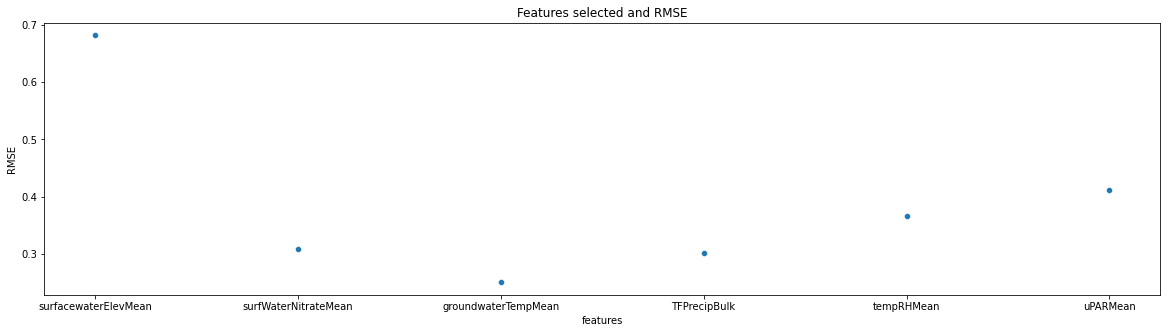

In [382]:
plt.figure(figsize=(20,5))
sns.scatterplot(data = final, x='features', y='RMSE')
plt.title('Features selected and RMSE');